In [33]:
# ==============================
# 📦 필수 모듈 로딩
# ==============================
import os
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

from itertools import product

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import joblib

# ==============================
# 💻 Device 설정
# ==============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cpu


In [34]:
import sklearn
print(sklearn.__version__)

1.7.0


In [35]:
import torch.version


torch.__version__

'2.7.0+cpu'

In [36]:
target_cols = ["D_배수지_유출유량2", "D_배수지_수위7_m3", "D_배수지_수위8_m3"]

In [37]:
save_dir = "./result"
os.makedirs(save_dir, exist_ok=True)

In [38]:
# 데이터 로딩
DATA = "./result/features.csv"
DF = pd.read_csv(DATA, encoding='utf-8-sig', parse_dates=['시각']).set_index('시각')

# 인덱스를 다시 '시각' 컬럼으로 복원
DF["시각"] = DF.index

# 확인
print(DF.head())

                     D_배수지_유출유량2  D_배수지_유입유량1  D_배수지_유입유량2  나단계_D배수지_유입유량1  \
시각                                                                           
2024-09-25 00:00:00    29.983333    73.791667    68.116667      136.216667   
2024-09-25 00:05:00    35.325000    74.933333    68.708333      137.108333   
2024-09-25 00:10:00    40.775000    73.525000    67.841667      134.900000   
2024-09-25 00:15:00    40.800000    77.616667    72.800000      145.091667   
2024-09-25 00:20:00    40.775000    79.441667    73.858333      147.475000   

                     D_배수지_유출개도2  D_배수지_유입개도2  D_배수지_유출개도1  D_배수지_유입개도1  \
시각                                                                        
2024-09-25 00:00:00    26.400000    99.856875    25.287500        100.0   
2024-09-25 00:05:00    26.390000    99.801875    25.312500        100.0   
2024-09-25 00:10:00    26.415000    99.820625    25.280625        100.0   
2024-09-25 00:15:00    26.428125    99.858750    25.299375        100.0   
202

In [39]:
# 수위7
shap_values_1, X_sub_1, top_idx_1 = joblib.load("./result/D_배수지_수위7_m3_shap.pkl")

# 수위8
shap_values_2, X_sub_2, top_idx_2 = joblib.load("./result/D_배수지_수위8_m3_shap.pkl")

# 유출유량2
shap_values_outflow, X_sub_outflow, top_idx_outflow = joblib.load("./result/D_배수지_유출유량2_shap.pkl")

#### 1. 입력 X 통합

In [40]:
# 세 피처 조합
all_features = list(set(X_sub_outflow.columns) | set(X_sub_1.columns) | set(X_sub_2.columns))

# 피처 데이터 추출 및 결측 제거
X_multi = DF[all_features].copy()
len(X_multi.columns), X_multi.columns

(37,
 Index(['D_배수지_유출유량2_15분이동평균', 'D_배수지_유출유량2_diff2', 'D_배수지_수위8_m3_lag2',
        'D_배수지_유출유량2_pct2', 'D_배수지_수위7_m3_lag2', 'D_배수지_유입개도2',
        'D_배수지_수위7_m3_15분이동평균', '시간_코사인', 'D_배수지_유출유량2_pct3',
        'D_배수지_수위7_m3_lag1', 'D_배수지_수위7_m3_diff3', 'D_배수지_수위8_m3_10분이동표준편차',
        'D_배수지_수위7_m3_lag3', 'D_배수지_유출유량2_diff1', 'D_배수지_수위7_m3_diff1',
        'D_배수지_수위8_m3_diff3', 'D_배수지_수위7_m3_10분이동평균', 'D_배수지_유출유량2_diff3',
        'D_배수지_유출유량2_lag2', 'D_배수지_유입유량2_10분이동평균', 'D_배수지_수위8_m3_diff2',
        '시간_float', 'D_배수지_수위8_m3_15분이동평균', 'D_배수지_수위7_m3_10분이동표준편차',
        'D_배수지_수위7_m3_15분이동표준편차', 'D_배수지_수위8_m3_diff1', 'D_배수지_수위8_m3_lag1',
        '나단계_D배수지_유입유량1_lag3', 'D_배수지_유출유량2_lag3', 'D_배수지_유입유량1_lag2',
        'D_배수지_수위8_m3_10분이동평균', 'D_배수지_유출유량2_lag1', 'D_배수지_유출유량2_pct1',
        'D_배수지_수위8_m3_15분이동표준편차', 'D_배수지_유출유량2_10분이동평균', 'D_배수지_수위7_m3_diff2',
        'D_배수지_수위8_m3_lag3'],
       dtype='object'))

#### 2. 출력 Y 구성 (Multi-target)

In [41]:
y_multi = DF[target_cols].copy()
len(y_multi.columns), y_multi.columns

(3, Index(['D_배수지_유출유량2', 'D_배수지_수위7_m3', 'D_배수지_수위8_m3'], dtype='object'))

#### 4. 정규화 방식 변경

- 기존 MinMaxScaler → StandardScaler

In [42]:
# 저장 폴더 생성
os.makedirs(save_dir, exist_ok=True)

# 1. X 정규화
X_multi_numeric = X_multi.select_dtypes(include=['float64', 'int64'])
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_multi_numeric)
X_scaled_multi_df = pd.DataFrame(X_scaled, columns=X_multi_numeric.columns, index=X_multi.index)

# 2. y 정규화
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_multi)
y_scaled_multi_df = pd.DataFrame(y_scaled, columns=y_multi.columns, index=y_multi.index)

# 3. 스케일러 저장
scaler_X_path = os.path.join(save_dir, "scaler_X.pkl")
scaler_y_path = os.path.join(save_dir, "scaler_y.pkl")

joblib.dump(scaler_X, scaler_X_path)
joblib.dump(scaler_y, scaler_y_path)

print(f"✅ 스케일러 저장 완료:\n- X 스케일러: {scaler_X_path}\n- y 스케일러: {scaler_y_path}")

✅ 스케일러 저장 완료:
- X 스케일러: ./result\scaler_X.pkl
- y 스케일러: ./result\scaler_y.pkl


In [43]:
# 1. Seed 고정
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    import random
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [44]:
# 2. 시퀀스 생성 함수
def create_sequences(X, Y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:i + seq_length])
        ys.append(Y[i + seq_length])
    return np.array(xs), np.array(ys)

In [45]:
import torch
import torch.nn as nn

# ✅ LSTM 기반 시계열 예측 신경망 클래스
class ImprovedLSTMModel(nn.Module):
    def __init__(
        self, input_dim,        # 입력 특성(변수) 개수 (예: 20개)
        hidden_dim,             # LSTM 셀 안에서 정보를 담는 공간 크기(차원)
        output_dim,             # 예측할 값의 개수 (예: 유출유량, 수위 등 3개)
        num_layers=1,           # LSTM 레이어(층)의 개수 (깊이)
        dropout=0.2,            # 드롭아웃 비율(일부 뉴런 임시 비활성화, 과적합 방지)
        bidirectional=True,     # 양방향 LSTM(과거→미래 + 미래→과거)
        use_batchnorm=True      # 배치 정규화 적용 여부 (학습 안정성, 속도 향상)
    ):
        super().__init__()      # PyTorch 신경망 기본 구조 불러오기

        # ① LSTM 레이어 정의 (시계열의 순서 정보를 학습)
        self.lstm = nn.LSTM(
            input_size=input_dim,         # 입력 특성 개수
            hidden_size=hidden_dim,       # 내부 상태 차원(정보 저장 공간)
            num_layers=num_layers,        # LSTM 층 수(여러 층 쌓기 가능)
            dropout=dropout if num_layers > 1 else 0, # 드롭아웃(여러 층일 때만 적용)
            batch_first=True,             # 입력 텐서의 첫 번째 축이 배치
            bidirectional=bidirectional   # 양방향 LSTM 사용 여부
        )

        # ② LSTM 출력의 차원 조정 (양방향일 경우 2배)
        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)

        # ③ Fully Connected(FC) 레이어 구성 (LSTM 결과 → 실제 예측값 변환)
        layers = []
        if use_batchnorm:
            # 배치 정규화(BatchNorm): 각 배치별로 값 분포 맞추기(학습 안정화)
            layers.append(nn.BatchNorm1d(lstm_out_dim))
        # 비선형 활성화 함수 (복잡한 패턴 학습)
        layers.append(nn.ReLU())
        # FC 레이어(선형 변환): LSTM의 출력(특성)을 실제 예측 개수(output_dim)로 변환
        layers.append(nn.Linear(lstm_out_dim, output_dim))
        # 순차적으로 연결 (FC 레이어 모듈로 저장)
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        # ④ LSTM에 입력 데이터 전달 (전체 시계열 구간 학습)
        out, _ = self.lstm(x)
        # ⑤ 시계열의 마지막 시점 정보만 추출 ([batch, 마지막 시점, 특성])
        out = out[:, -1, :]
        # ⑥ FC 레이어를 통해 실제 예측값(유출유량, 수위 등) 출력
        return self.fc_layers(out)

In [46]:
# ✅ LSTM 모델 학습 함수 (훈련 + 검증 + 조기 종료 포함)
def train_model(
    model,               # 학습시킬 LSTM 모델 객체
    train_loader,        # 훈련 데이터 (미니배치로 불러오기 위한 DataLoader)
    val_loader,          # 검증 데이터 (모델 성능 점검용 DataLoader)
    criterion,           # 손실 함수 (예측값과 실제값 차이 계산)
    optimizer,           # 최적화 기법 (예: Adam)
    device,              # 학습할 기기(cpu 또는 gpu)
    target_cols,         # 예측 타겟(컬럼) 이름 리스트
    num_epochs=30,       # 전체 에포크(전체 데이터 여러 번 반복 학습) 수
    patience=5           # 조기 종료를 위한 허용 인내 에포크 수
):
    model.to(device)     # 모델을 지정한 디바이스(GPU/CPU)로 옮김

    best_val_loss = float('inf')     # 검증 손실(낮을수록 좋음) 중 최고 기록 저장
    patience_counter = 0             # 성능 개선이 없을 때 카운트 증가

    # 검증 손실 저장 (타겟별로 리스트 생성)
    val_loss_per_target = {k: [] for k in target_cols}
    # 훈련 손실 저장
    train_loss_per_epoch = []

    for epoch in range(num_epochs):  # 지정한 에포크 수만큼 반복
        model.train()                # 모델을 학습모드로 설정 (가중치 조정 O)
        train_losses = []            # 이번 에포크의 배치별 손실 기록

        for X_batch, y_batch in train_loader:     # 훈련 배치 반복
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()                # 기울기(gradient) 초기화
            output = model(X_batch)              # 입력 데이터를 모델에 넣어 예측값 얻음
            loss = criterion(output, y_batch).mean()   # 손실(예측값과 실제값 차이 평균)
            loss.backward()                      # 손실을 기준으로 역전파(가중치 업데이트 방향 계산)
            optimizer.step()                     # 실제로 가중치 업데이트(한걸음 학습)
            train_losses.append(loss.item())      # 손실값 저장

        avg_train_loss = np.mean(train_losses)    # 에포크별 훈련 손실 평균
        train_loss_per_epoch.append(avg_train_loss)

        model.eval()                             # 모델을 평가모드로 설정 (가중치 고정, Dropout 등 해제)
        val_losses = []                          # 검증 손실값 모음

        with torch.no_grad():                    # 평가 중에는 역전파(가중치 수정) 비활성화
            for X_val, y_val in val_loader:      # 검증 데이터 배치 반복
                X_val, y_val = X_val.to(device), y_val.to(device)
                output = model(X_val)            # 예측값 생성
                loss_all = criterion(output, y_val)   # 손실 계산 (배치별, 타겟별)
                val_losses.append(loss_all.cpu().numpy())  # numpy로 변환 후 저장

        val_losses_np = np.concatenate(val_losses, axis=0)   # 전체 검증 손실 합치기
        avg_val_loss = np.mean(val_losses_np)                # 검증 손실 평균

        # 타겟별로 손실값을 계산하여 저장 (모니터링용)
        for i, name in enumerate(target_cols):
            val_loss_per_target[name].append(np.mean(val_losses_np[:, i]))

        # 조기 종료 조건 체크 (최고 기록 경신 시)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0                # 개선 시 인내 카운터 초기화
        else:
            patience_counter += 1               # 개선 없으면 카운터 증가
            if patience_counter >= patience:    # 개선 없던 에포크가 기준 넘으면 중단
                print(f"⏹️ 조기 종료: epoch {epoch+1}")
                break

    # 학습이 끝나면 (또는 조기 종료되면) 모델과 손실 히스토리 리턴
    return model, {
        'val_loss_per_target': val_loss_per_target,   # 타겟별 검증 손실 기록
        'train_loss_per_epoch': train_loss_per_epoch  # 에포크별 훈련 손실 기록
    }

In [47]:
# 5. TimeSeriesSplit 기반 그리드서치
def grid_search_lstm(
    X_scaled, y, param_grid, target_cols, device, tscv, num_epochs=30, seed=42
):
    set_seed(seed)  # 매번 같은 결과를 얻기 위해 시드 고정

    # 하이퍼파라미터 조합을 모두 펼쳐서 리스트로 생성 (모든 경우 탐색)
    param_list = list(product(*param_grid.values()))

    # 가장 좋은(낮은) 검증 손실을 저장
    best_score = float('inf')
    best_model = None
    best_params = None
    best_losses = None
    best_fold_scores = None

    # 각 하이퍼파라미터 조합별로 반복
    for i, (hidden_dim, num_layers, dropout, lr, seq_length, batch_size) in enumerate(param_list, 1):
        print(f"\n🔁 {i}/{len(param_list)} - 조합: hidden={hidden_dim}, layers={num_layers}, "
              f"dropout={dropout}, lr={lr}, seq_len={seq_length}, batch={batch_size}")

        # 시퀀스 데이터 생성 (입력/출력을 'seq_length'만큼씩 분할)
        X_seq, y_seq = create_sequences(X_scaled, y, seq_length)
        fold_scores = []

        # TimeSeriesSplit 기반 교차검증 반복
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_seq)):
            print(f"  ➤ Fold {fold+1}/{tscv.n_splits}")

            # 훈련/검증 데이터 분할
            X_train, X_val = X_seq[train_idx], X_seq[val_idx]
            y_train, y_val = y_seq[train_idx], y_seq[val_idx]

            # PyTorch 텐서로 변환
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

            # DataLoader 생성 (미니배치 학습용)
            train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=False)
            val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

            # LSTM 모델 생성 (현재 조합의 하이퍼파라미터 사용)
            model = ImprovedLSTMModel(
                input_dim=X_scaled.shape[1],
                hidden_dim=hidden_dim,
                output_dim=y.shape[1],
                num_layers=num_layers,
                dropout=dropout,
                bidirectional=True,
                use_batchnorm=True
            )
            criterion = torch.nn.MSELoss(reduction='none')  # 다중 타겟에 대해 개별 오차 계산
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # 실제 모델 훈련 (학습 함수 호출)
            model, losses = train_model(
                model, train_loader, val_loader, criterion, optimizer, device, target_cols, num_epochs=num_epochs
            )
            # 해당 fold에서의 검증 손실(첫번째 타겟 기준)
            target_key = target_cols[0]
            val_loss = min(losses['val_loss_per_target'][target_key])
            fold_scores.append(val_loss)  # fold별 검증 손실값 저장

        # 모든 fold의 평균 성능 산출 (이 조합의 종합 성적표)
        avg_score = np.mean(fold_scores)
        print(f"  [평균 Fold Val Loss] {avg_score:.4f}")

        # 최고 기록 갱신 시, 결과 저장
        if avg_score < best_score:
            best_score = avg_score
            best_model = model
            best_params = {
                'hidden_dim': hidden_dim,
                'num_layers': num_layers,
                'dropout': dropout,
                'lr': lr,
                'seq_length': seq_length,
                'batch_size': batch_size
            }
            best_losses = losses
            best_fold_scores = fold_scores
            print("✅ New Best Score!")  # 최고 기록 갱신 알림

    # 전체 탐색 후 최적 모델, 파라미터, 학습 기록 반환
    print(f"\n🎯 Best CV Loss ({target_key}): {best_score:.4f}")
    print("Best Params:", best_params)
    return best_model, best_params, best_losses, best_fold_scores


In [48]:
# loss/val loss 그래프 그리기 함수
def plot_train_val_loss(loss_dict, target_cols):
    train_loss = loss_dict.get('train_loss_per_epoch', None)
    val_loss_dict = loss_dict['val_loss_per_target']

    for name in target_cols:
        plt.figure(figsize=(10, 5))
        plt.title(f"[{name}] Train vs Val Loss")
        if train_loss:
            plt.plot(train_loss, label="Train Loss", linestyle="--", color="black")
        plt.plot(val_loss_dict[name], label="Val Loss", color="blue")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [51]:
# ✅ 멀티타겟 모델 평가 및 시각화 함수 (전체/하루/1시간 확대)
def evaluate_multi_output(
    model, X_tensor, y_tensor, device, target_cols, scaler_y=None, label='Test', time_index=None,
    plot_zoom=True, save_dir=save_dir
):
    model.eval()  # 평가모드 전환 (dropout 등 비활성)
    with torch.no_grad():
        # 예측 결과 생성 (배치 단위 추론, GPU/CPU 모두 지원)
        y_pred = model(X_tensor.to(device)).cpu().numpy()
        y_true = y_tensor.cpu().numpy()
    # 필요시 역정규화 (원래 스케일로 복원)
    if scaler_y is not None:
        y_pred = scaler_y.inverse_transform(y_pred)
        y_true = scaler_y.inverse_transform(y_true)
    print(f"\n📊 {label} 성능:")
    results = {}
    for i, name in enumerate(target_cols):
        y_t = y_true[:, i]  # 실제값 (i번째 타겟)
        y_p = y_pred[:, i]  # 예측값
        # RMSE, MAE, R² 등 주요 성능지표 계산
        rmse = np.sqrt(np.mean((y_t - y_p) ** 2))
        mae = mean_absolute_error(y_t, y_p)
        r2 = r2_score(y_t, y_p)
        print(f" - [{name}] RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
        # x축 (시각) 설정: 시간 인덱스 있으면 사용, 없으면 그냥 0~N
        x_axis = time_index if time_index is not None else np.arange(len(y_t))

        # 전체 시계열 구간 그래프
        plt.figure(figsize=(12, 4))
        plt.plot(x_axis, y_t, label='실제값', color='black')
        plt.plot(x_axis, y_p, label='예측값', color='blue', linestyle='--', alpha=0.6)
        plt.title(f"{label} - {name} (전체)", fontsize=13)
        plt.xlabel("시각")
        plt.ylabel("값")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

        # 마지막 하루/1시간만 확대해서 추가 시각화 (옵션)
        if plot_zoom and len(y_t) > 288:  # 5분 단위 데이터라면 288개가 1일
            for zoom, zname in zip([288, 12], ['하루', '1시간']):
                plt.figure(figsize=(14, 5 if zoom == 288 else 4))
                plt.plot(x_axis[-zoom:], y_t[-zoom:], label='실제값', color='black')
                plt.plot(x_axis[-zoom:], y_p[-zoom:], label='예측값', color='blue', linestyle='--', alpha=0.6)
                plt.title(f"[{zname} 확대] {label} - {name}", fontsize=12)
                plt.legend()
                plt.grid(True)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
    # 최종적으로 실제값, 예측값, 지표 결과 딕셔너리 반환
    return y_true, y_pred, results

In [18]:
# 7. 성능 요약 DataFrame
def get_perf_df(result_dict):
    df_perf = pd.DataFrame({
        (setname, metric, target): value
        for setname, results in result_dict.items()
        for target, metrics in results.items()
        for metric, value in metrics.items()
    }, index=[0])
    df_perf = df_perf.T.reset_index()
    df_perf.columns = ['Dataset', 'Metric', 'Target', 'Value']
    return df_perf.pivot_table(index=['Target', 'Metric'], columns='Dataset', values='Value')

#### 그리드 서치 준비 및 실행

In [19]:
#param_grid = {
#    'hidden_dim': [32, 64],
#    'num_layers': [1, 2],
#    'dropout': [0.2],
#    'lr': [0.001],
#    'seq_length': [12, 24],
#    'batch_size': [32, 64]
#}
#tscv = TimeSeriesSplit(n_splits=5)

#best_model, best_params, losses, fold_scores = grid_search_lstm(
#    X_scaled, y_scaled, param_grid, target_cols,
#    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
#    tscv=tscv, num_epochs=30, seed=42
#)

In [ ]:
param_grid = {
    'hidden_dim': [64],
    'num_layers': [2],
    'dropout': [0.2],
    'lr': [0.001],
    'seq_length': [24],
    'batch_size': [64]
}
tscv = TimeSeriesSplit(n_splits=5)

best_model, best_params, losses, fold_scores = grid_search_lstm(
    X_scaled, y_scaled, param_grid, target_cols,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    tscv=tscv, num_epochs=30, seed=42
)


🔁 1/1 - 조합: hidden=64, layers=2, dropout=0.2, lr=0.001, seq_len=24, batch=64
  ➤ Fold 1/5
⏹️ 조기 종료: epoch 9
  ➤ Fold 2/5
⏹️ 조기 종료: epoch 24
  ➤ Fold 3/5
⏹️ 조기 종료: epoch 26
  ➤ Fold 4/5
⏹️ 조기 종료: epoch 22
  ➤ Fold 5/5
⏹️ 조기 종료: epoch 30
  [평균 Fold Val Loss] 0.0046
✅ New Best Score!

🎯 Best CV Loss (D_배수지_유출유량2): 0.0046
Best Params: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'seq_length': 24, 'batch_size': 64}


In [ ]:
# 1. 모델 저장 (.pkl) - PyTorch 모델은 state_dict로 저장 권장, 여기선 joblib로 직렬화(실험/재현용)
model_path = os.path.join(save_dir, "best_lstm_model.pkl")
joblib.dump(best_model, model_path)

# 2. 하이퍼파라미터 저장 (.json)
params_path = os.path.join(save_dir, "best_lstm_params.json")
with open(params_path, "w") as f:
    json.dump(best_params, f, indent=4)

# 3. 손실 히스토리 저장 (.pkl)
losses_path = os.path.join(save_dir, "best_lstm_losses.pkl")
joblib.dump(losses, losses_path)

# 4. fold별 최종 val loss 저장 (.npy)
fold_scores_path = os.path.join(save_dir, "best_lstm_fold_scores.npy")
np.save(fold_scores_path, np.array(fold_scores))

print("✅ 모델, 파라미터, 손실 히스토리, fold별 val loss 저장 완료:")
print(f"   - 모델: {model_path}")
print(f"   - 파라미터: {params_path}")
print(f"   - 손실 히스토리: {losses_path}")
print(f"   - fold별 val loss: {fold_scores_path}")


✅ 모델, 파라미터, 손실 히스토리, fold별 val loss 저장 완료:
   - 모델: ./result\best_lstm_model.pkl
   - 파라미터: ./result\best_lstm_params.json
   - 손실 히스토리: ./result\best_lstm_losses.pkl
   - fold별 val loss: ./result\best_lstm_fold_scores.npy


#### 최적 시퀀스 길이로 split 및 텐서 변환

In [22]:
seq_length = best_params['seq_length']
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)
split1 = int(0.7 * len(X_seq))
split2 = int(0.85 * len(X_seq))

X_train, X_val, X_test = X_seq[:split1], X_seq[split1:split2], X_seq[split2:]
y_train, y_val, y_test = y_seq[:split1], y_seq[split1:split2], y_seq[split2:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### 인덱스 생성

In [23]:
full_index = y_scaled_multi_df.index[seq_length:]
train_index = full_index[:split1]
val_index = full_index[split1:split2]
test_index = full_index[split2:]

#### 모델 평가 및 성능 요약


📊 Train 성능:
 - [D_배수지_유출유량2] RMSE: 4.7017, MAE: 3.2351, R²: 0.9040


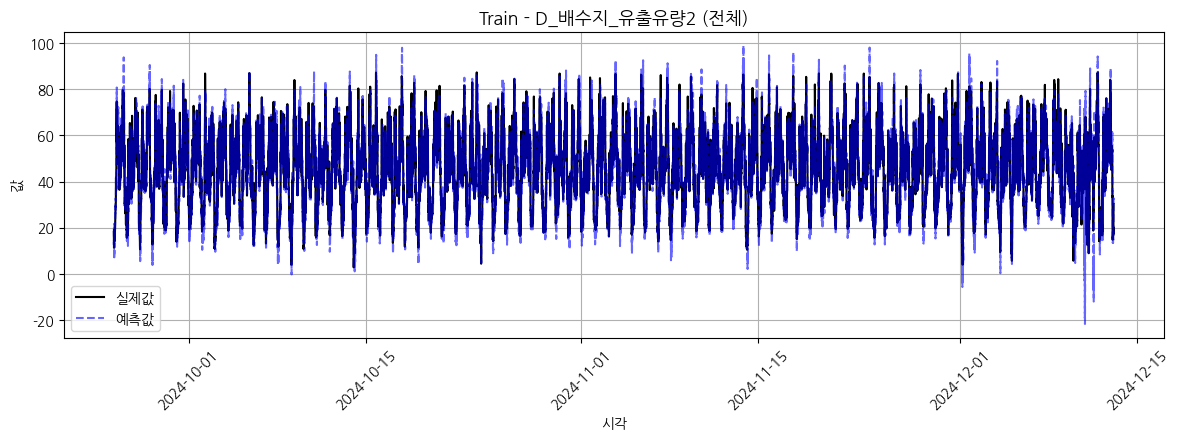

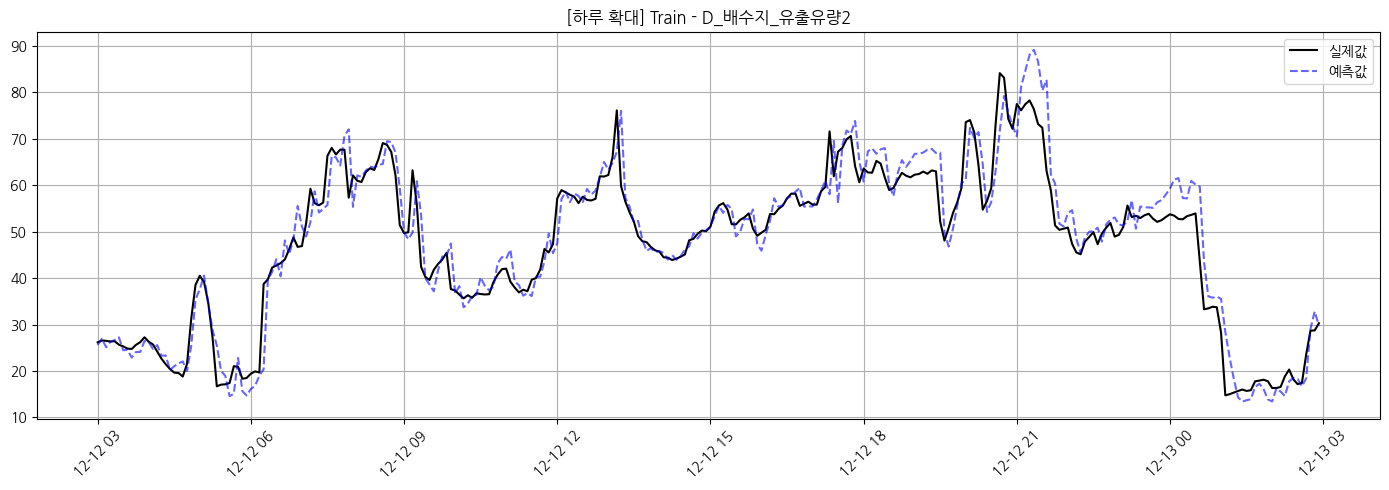

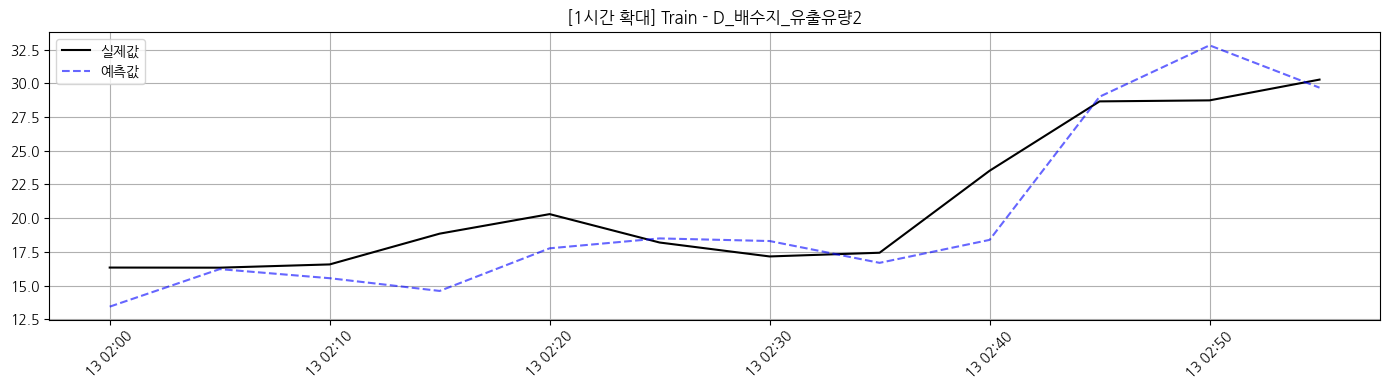

 - [D_배수지_수위7_m3] RMSE: 175.0282, MAE: 62.4730, R²: 0.9116


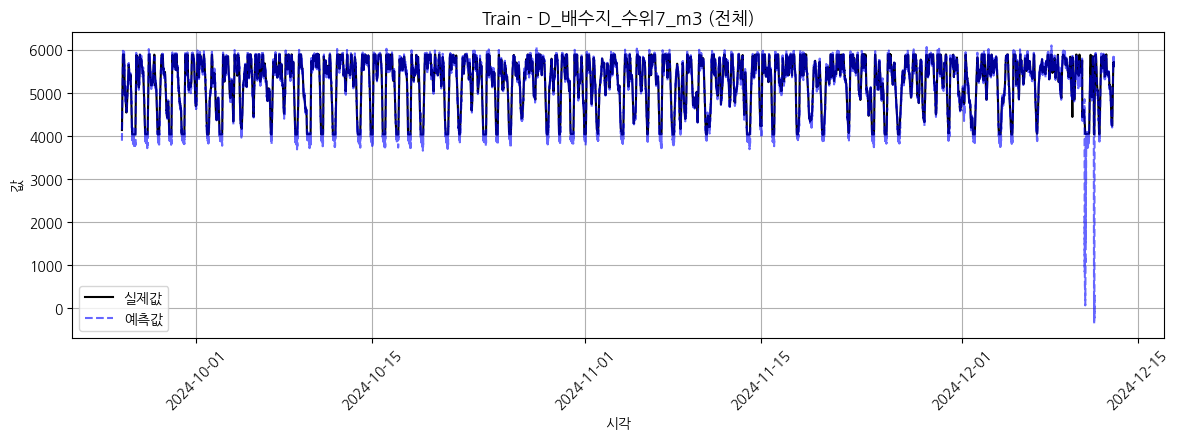

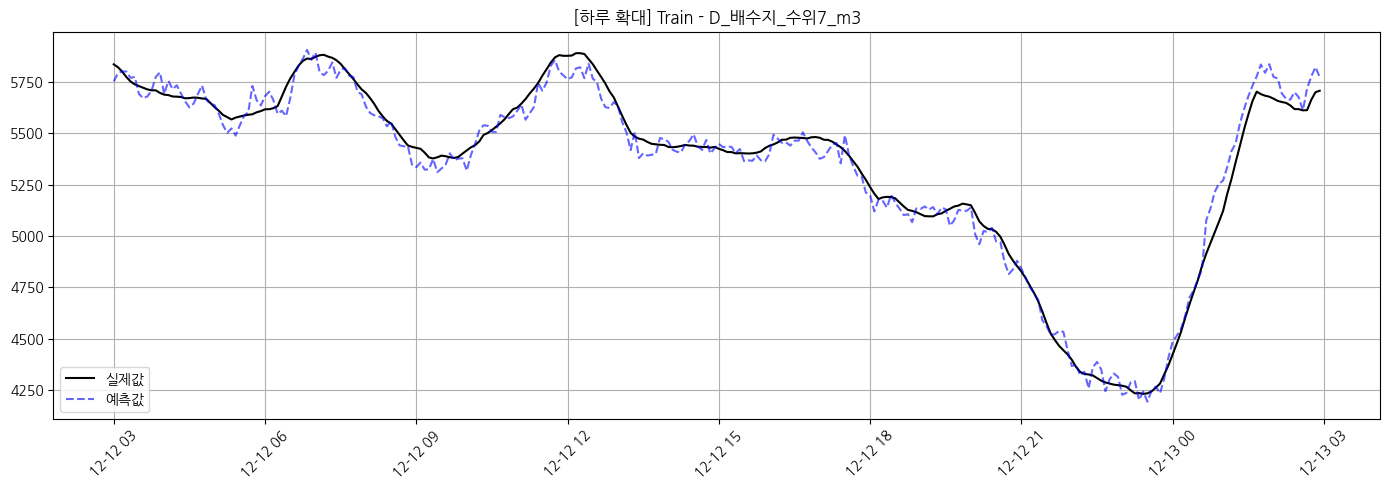

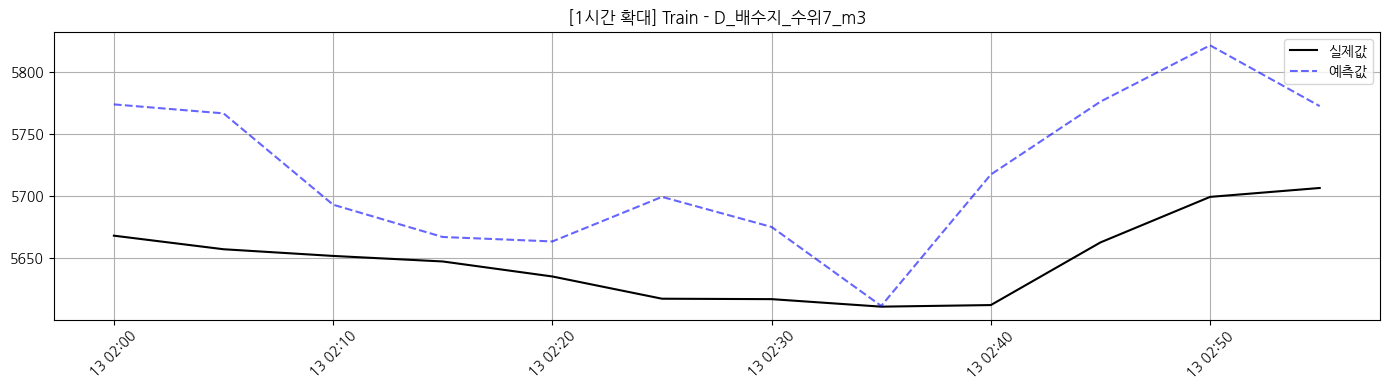

 - [D_배수지_수위8_m3] RMSE: 135.9374, MAE: 62.5027, R²: 0.9480


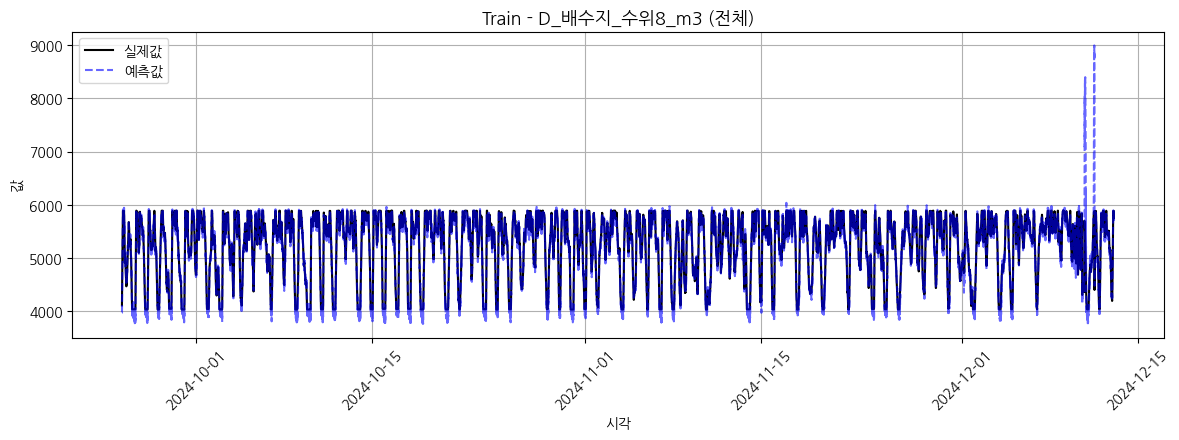

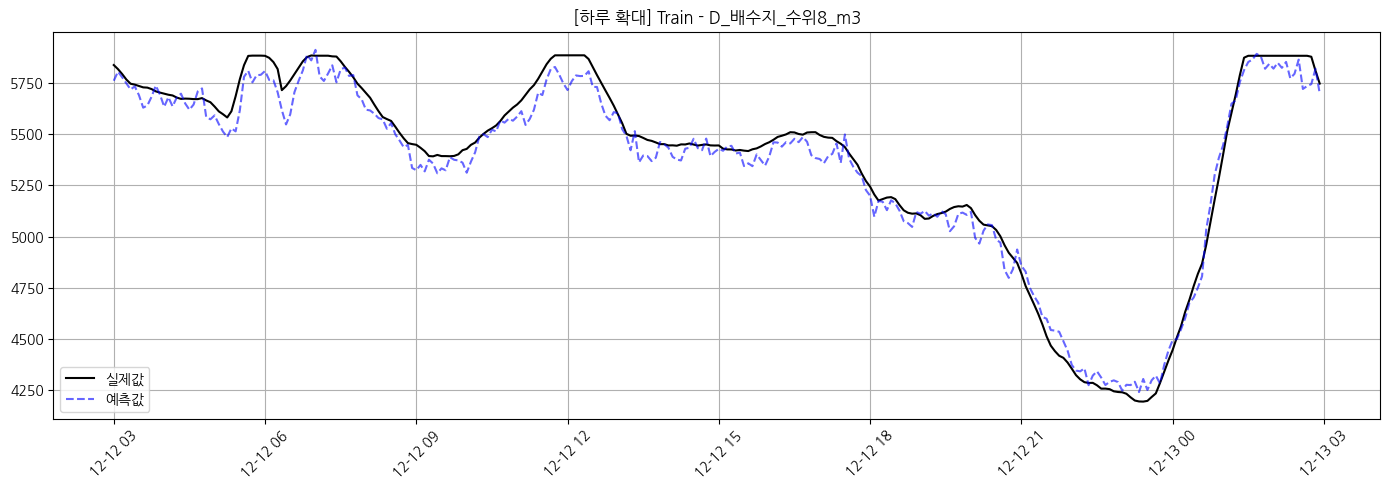

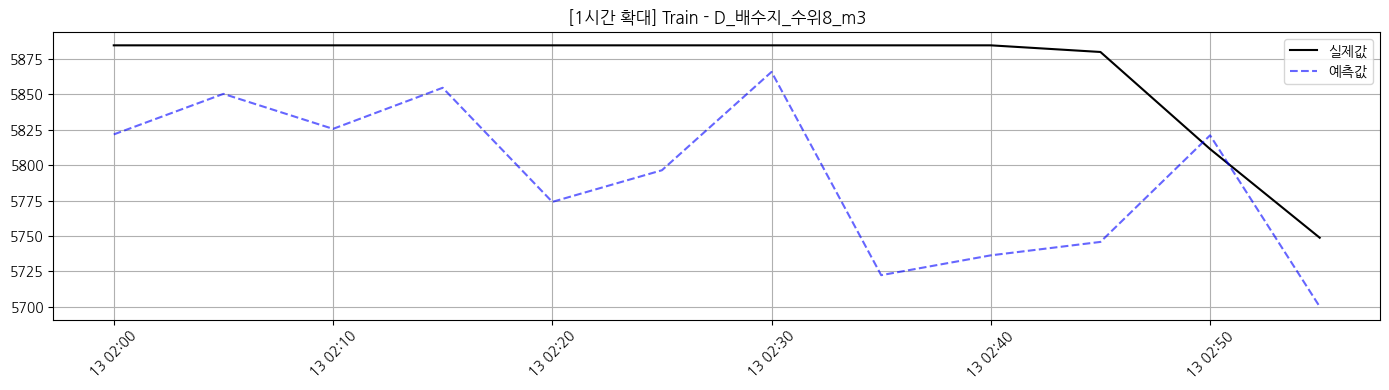


📊 Validation 성능:
 - [D_배수지_유출유량2] RMSE: 4.0194, MAE: 2.8880, R²: 0.9202


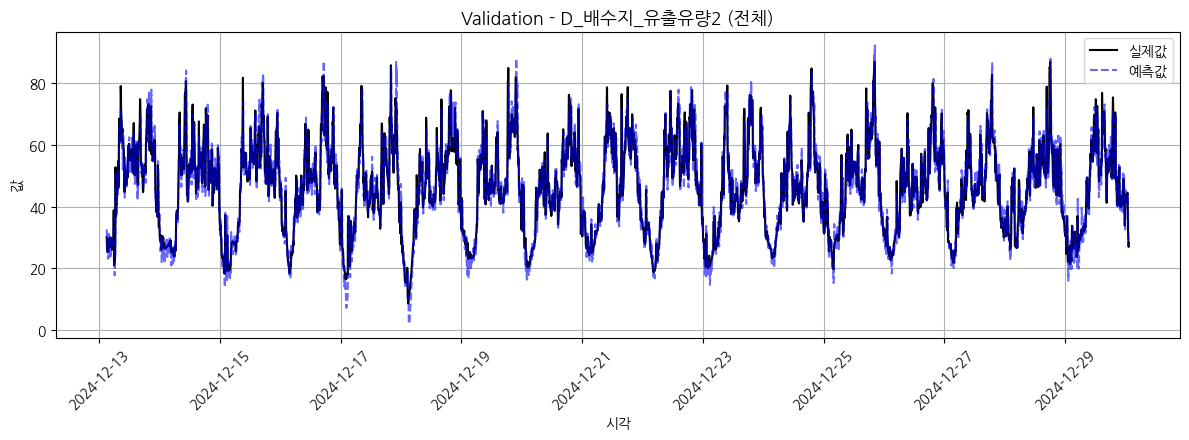

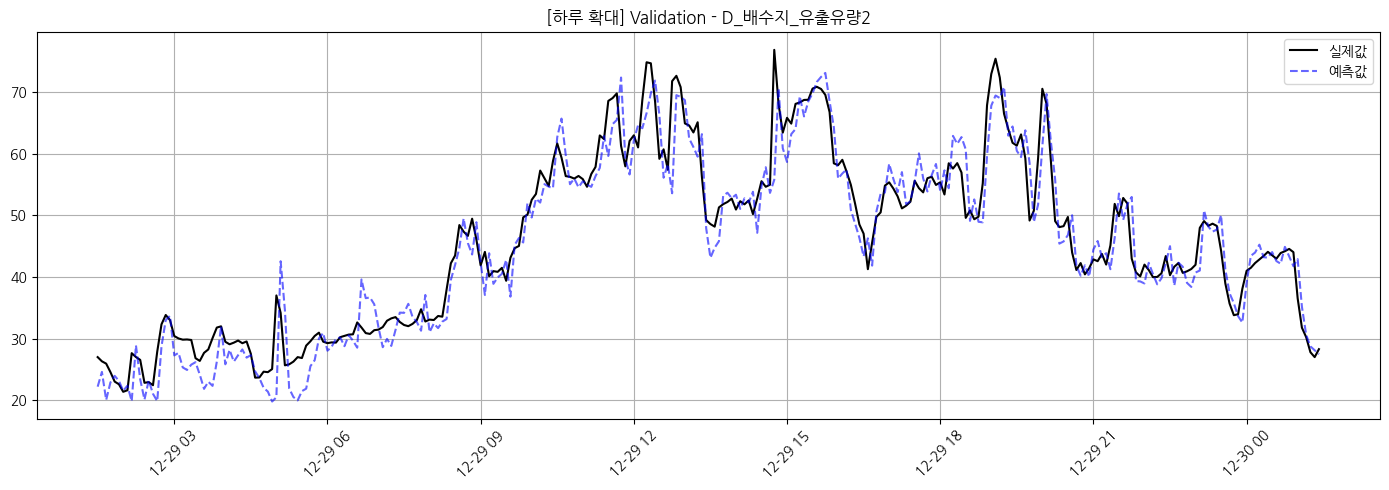

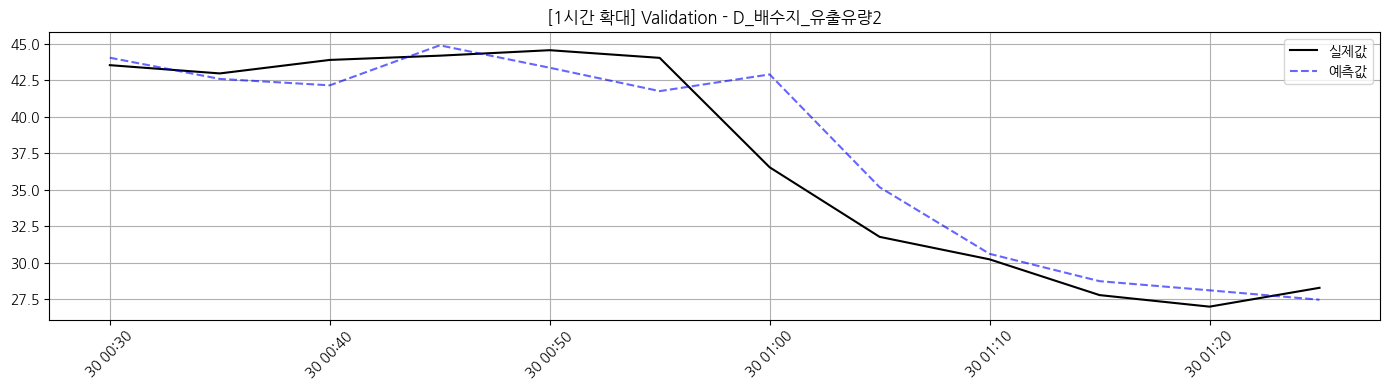

 - [D_배수지_수위7_m3] RMSE: 58.4202, MAE: 44.4706, R²: 0.9811


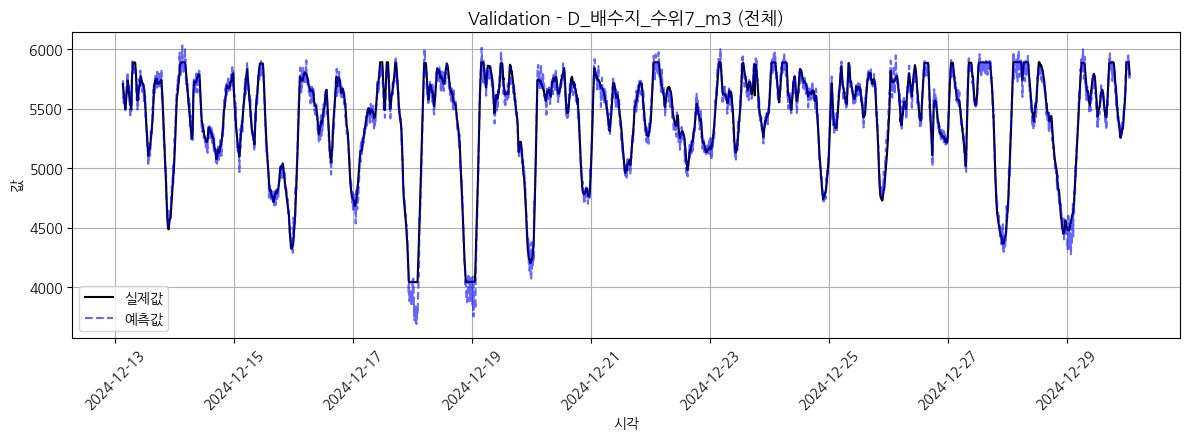

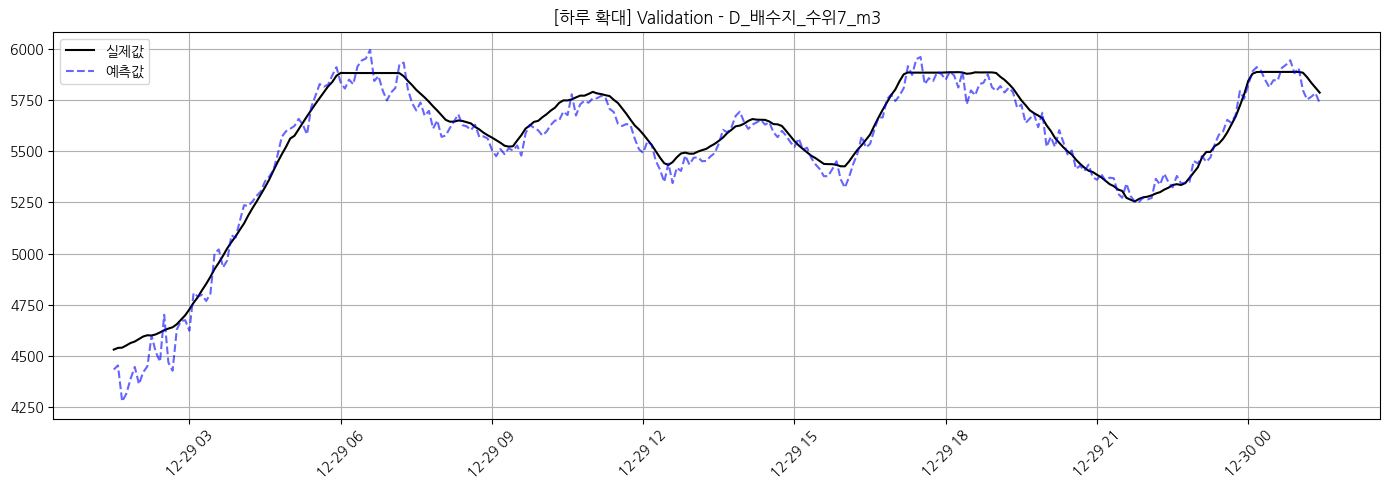

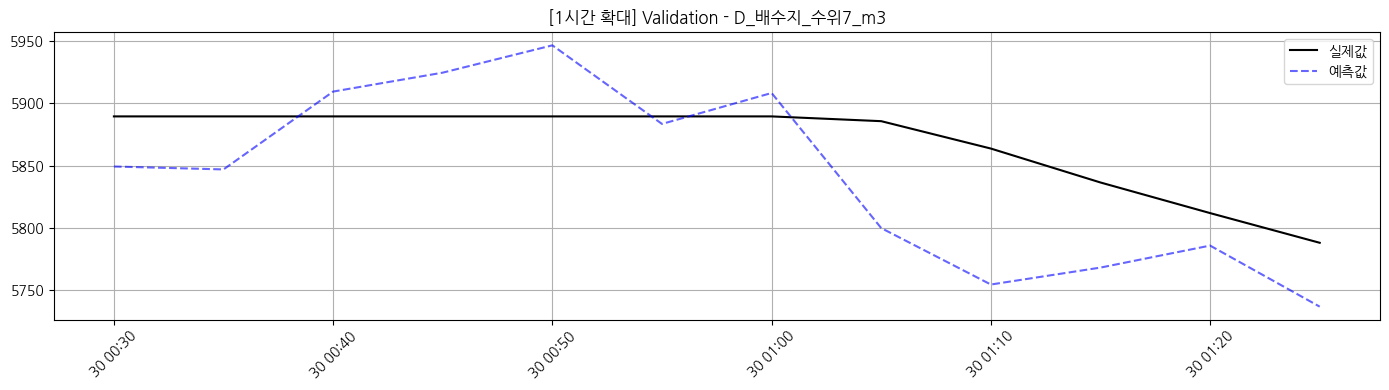

 - [D_배수지_수위8_m3] RMSE: 60.6387, MAE: 48.3060, R²: 0.9801


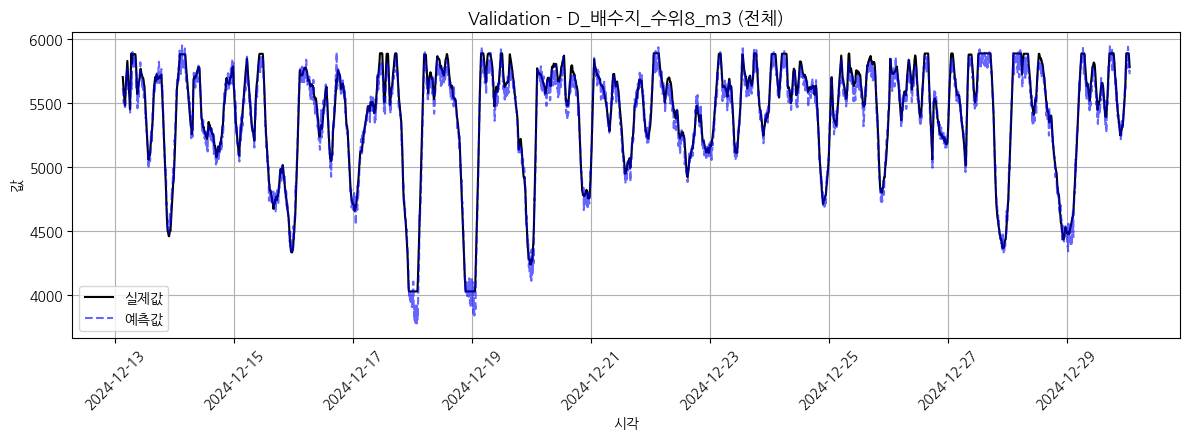

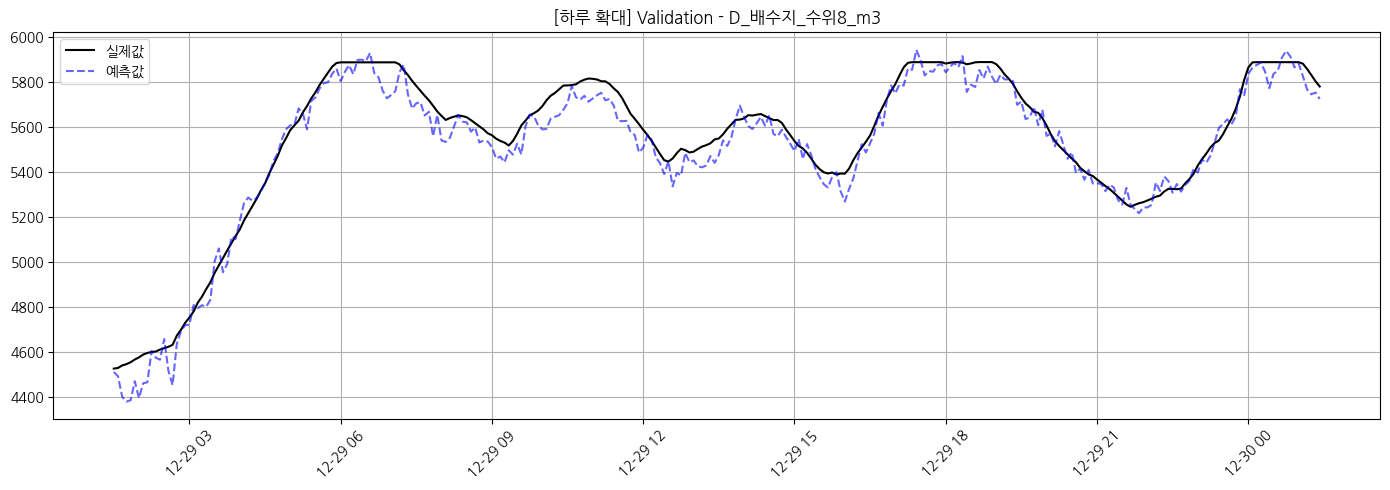

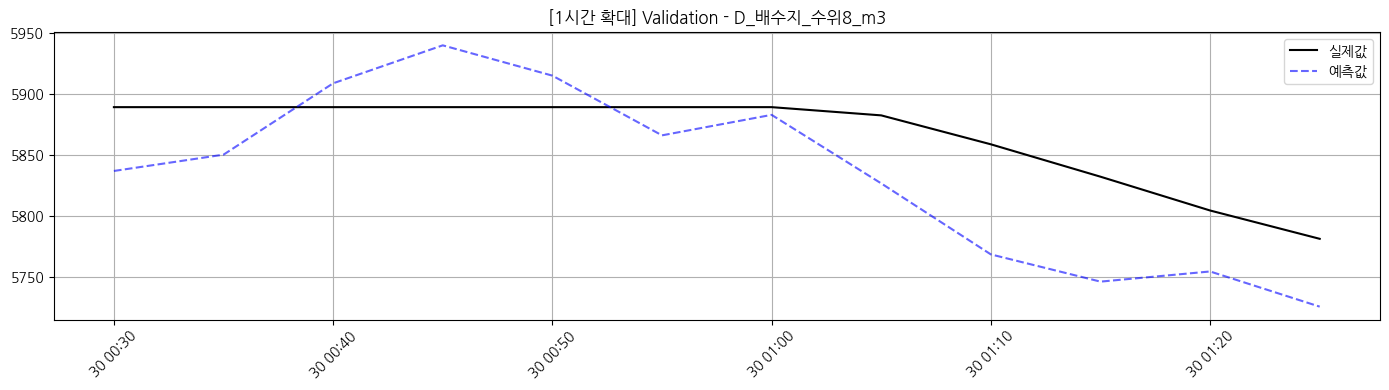


📊 Test 성능:
 - [D_배수지_유출유량2] RMSE: 3.9448, MAE: 2.7583, R²: 0.9093


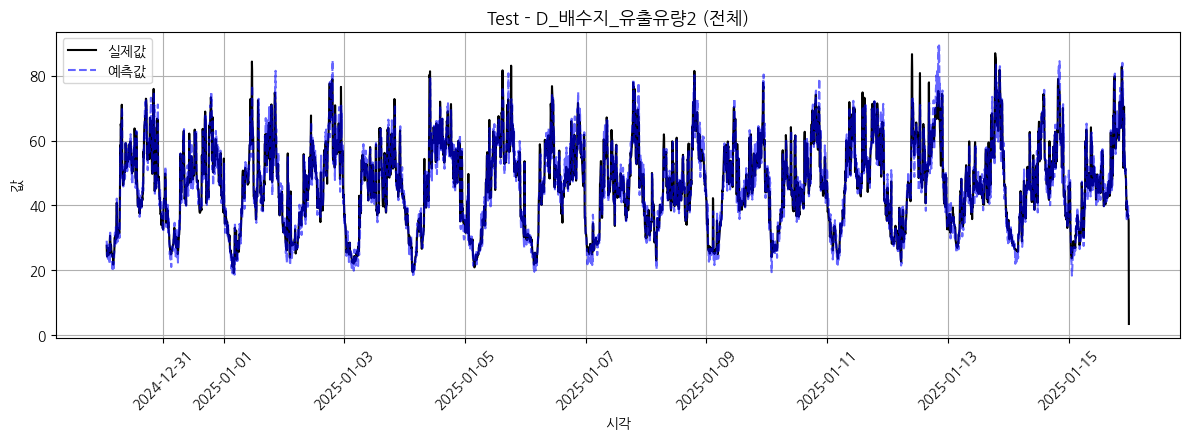

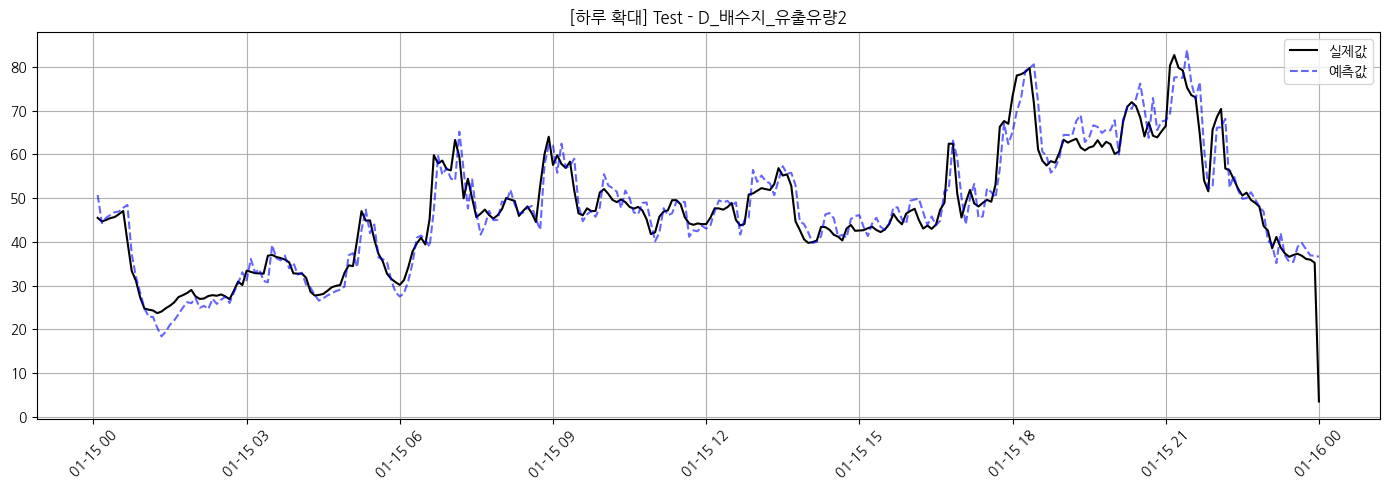

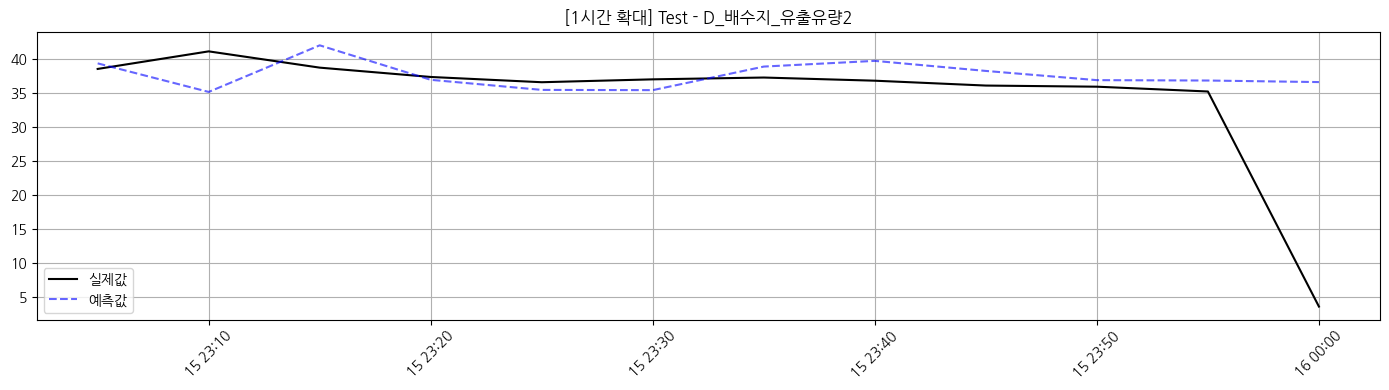

 - [D_배수지_수위7_m3] RMSE: 53.3602, MAE: 42.0980, R²: 0.9778


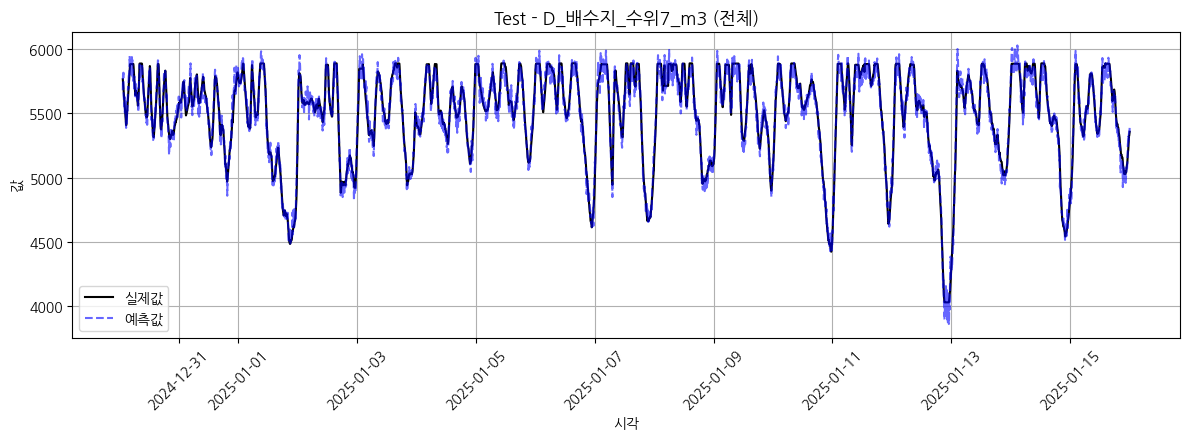

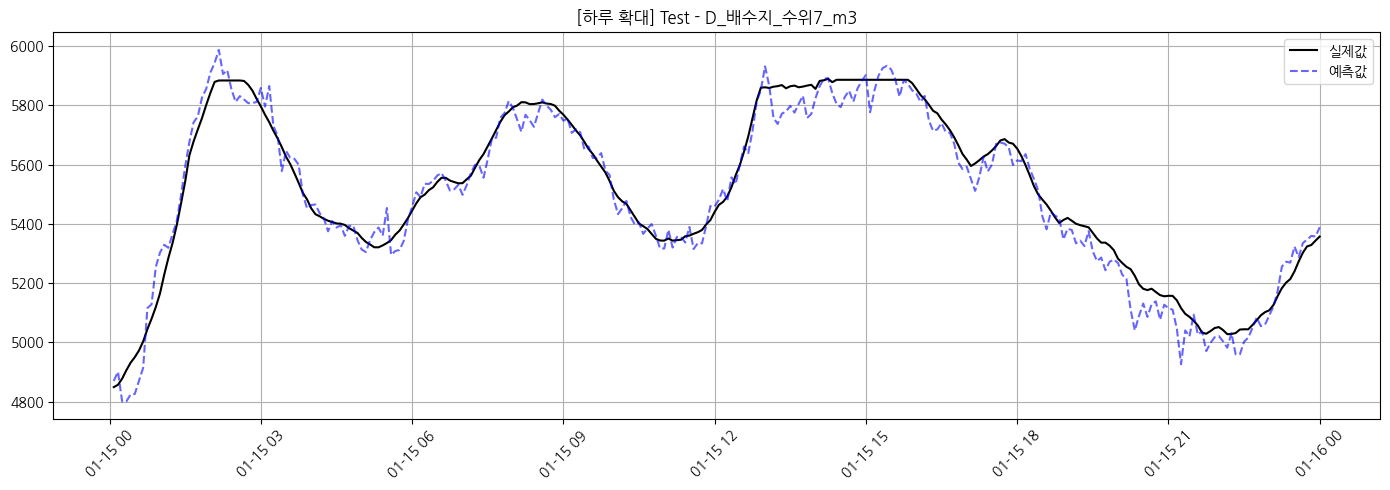

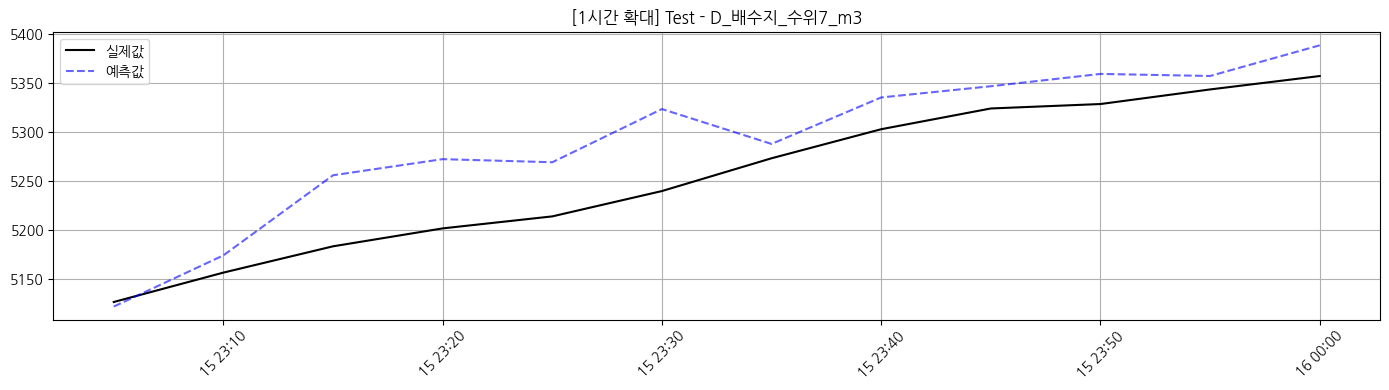

 - [D_배수지_수위8_m3] RMSE: 61.9047, MAE: 50.5563, R²: 0.9721


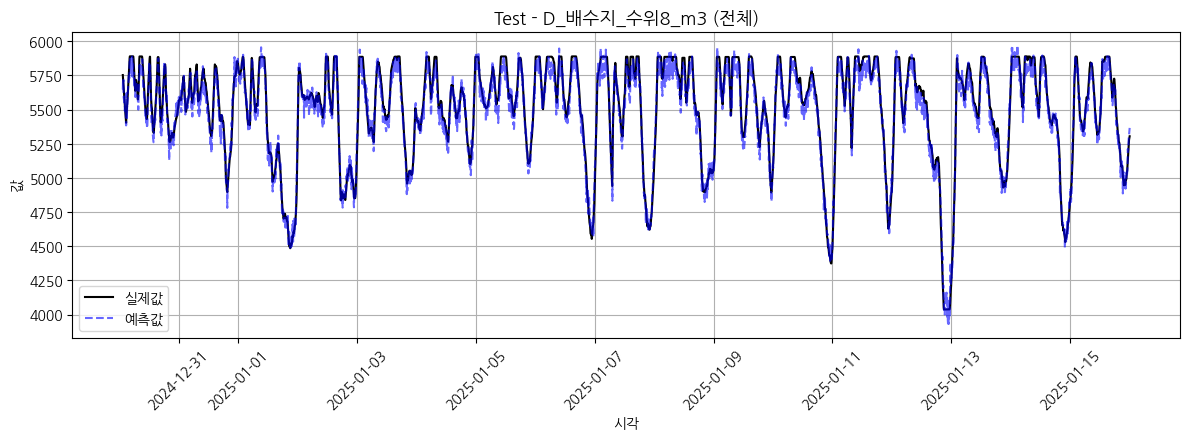

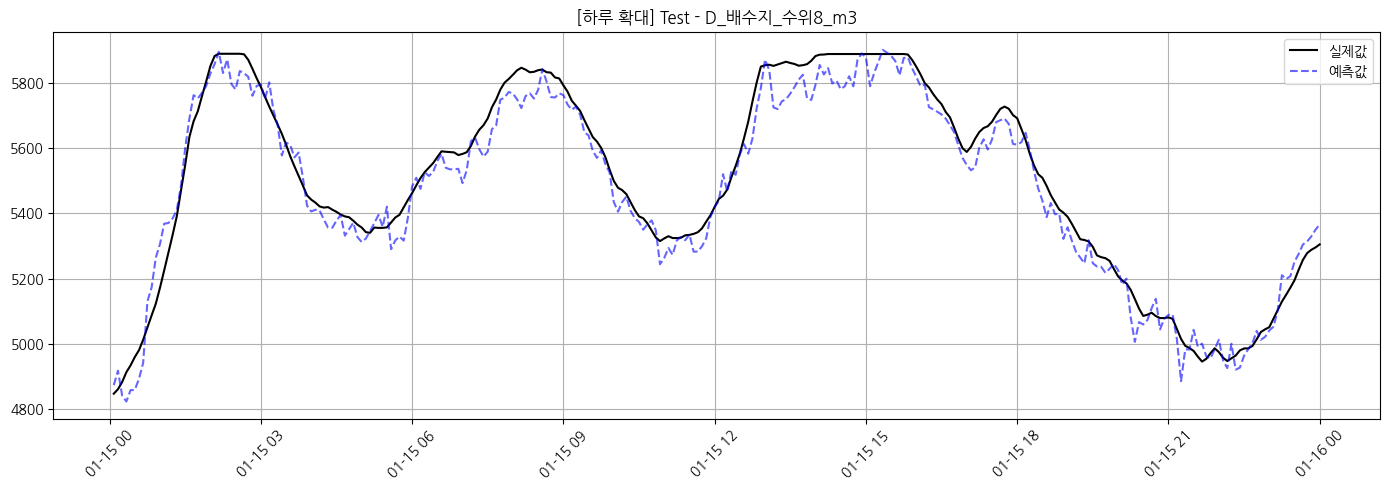

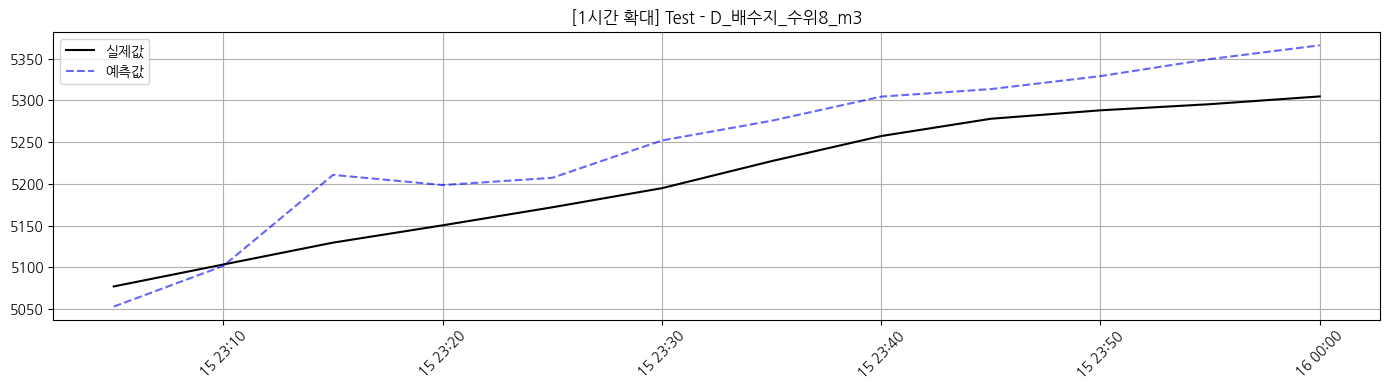

In [52]:
result_dict = {}
for (X_tensor, y_tensor, label, idx) in [
    (X_train_tensor, y_train_tensor, 'Train', train_index),
    (X_val_tensor, y_val_tensor, 'Validation', val_index),
    (X_test_tensor, y_test_tensor, 'Test', test_index)
]:
    _, _, res = evaluate_multi_output(
        best_model, X_tensor, y_tensor, torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        target_cols, scaler_y=scaler_y, label=label, time_index=idx, plot_zoom=True
    )
    result_dict[label] = res


#### loss/val loss 곡선, fold별 최종 val loss

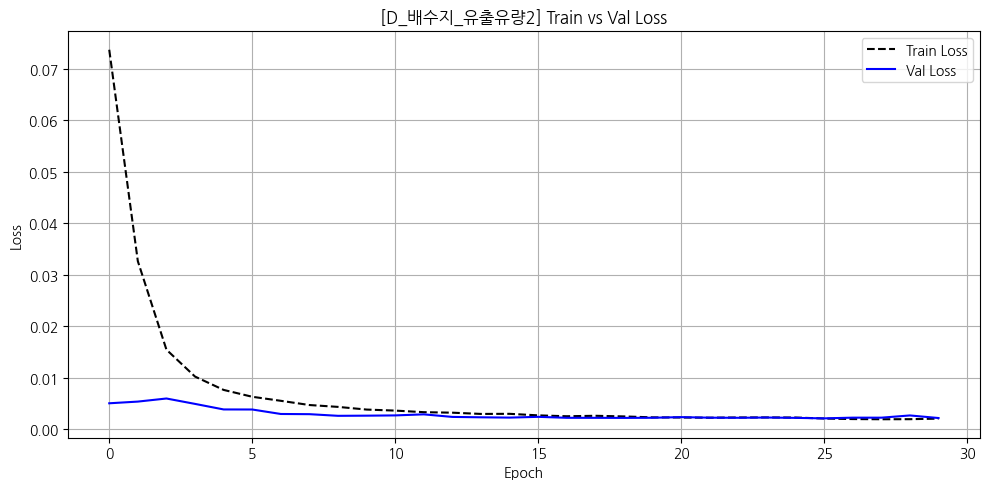

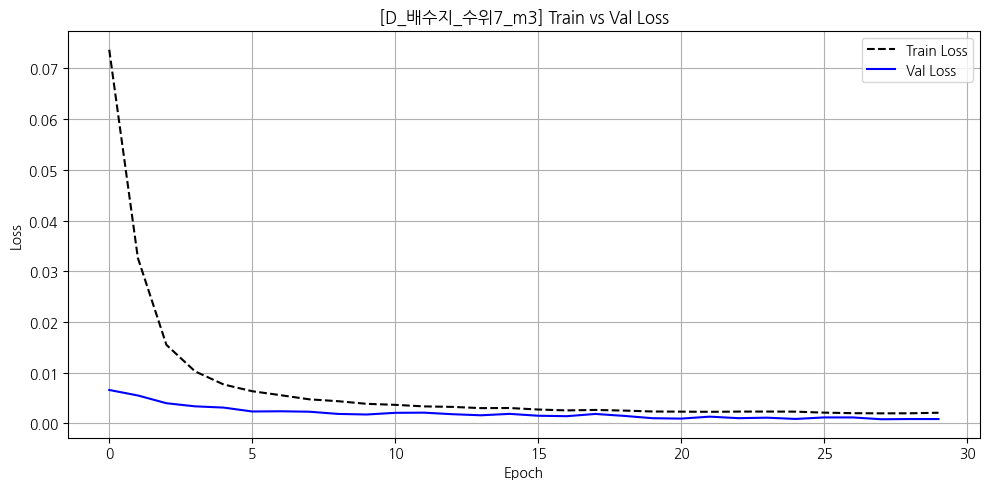

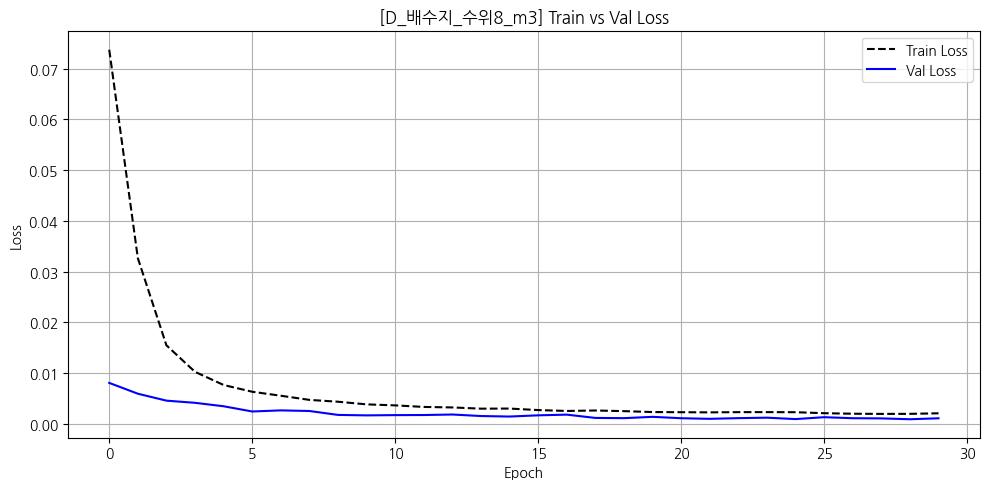

fold별 최종 val loss: [np.float32(0.009423421), np.float32(0.0032618882), np.float32(0.005076839), np.float32(0.003248532), np.float32(0.002150196)]


In [ ]:
plot_train_val_loss(losses, target_cols)
print("fold별 최종 val loss:", fold_scores)

In [26]:
print("fold별 최종 val loss:", fold_scores)
print("평균:", np.mean(fold_scores), "표준편차:", np.std(fold_scores))

fold별 최종 val loss: [np.float32(0.009423421), np.float32(0.0032618882), np.float32(0.005076839), np.float32(0.003248532), np.float32(0.002150196)]
평균: 0.0046321754 표준편차: 0.0025731744


#### 성능 데이터프레임 변환

In [ ]:
df_perf_pivot = get_perf_df(result_dict)
df_perf_pivot.round(4)

Dataset                 Test     Train  Validation
Target       Metric                               
D_배수지_수위7_m3 MAE     42.0980   62.4730     44.4706
             R2       0.9778    0.9116      0.9811
             RMSE    53.3602  175.0282     58.4202
D_배수지_수위8_m3 MAE     50.5563   62.5027     48.3060
             R2       0.9721    0.9480      0.9801
             RMSE    61.9047  135.9374     60.6387
D_배수지_유출유량2  MAE      2.7583    3.2351      2.8880
             R2       0.9093    0.9040      0.9202
             RMSE     3.9448    4.7017      4.0194

In [28]:
# 예측(최적 모델 적용)
with torch.no_grad():
    y_pred = best_model(X_test_tensor.to(device)).cpu().numpy()

# 실제값
y_true = y_test_tensor.cpu().numpy()

# 역정규화
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_true)

# 인덱스(시각)
test_index = y_scaled_multi_df.index[-len(y_test):]  # or 위에서 만든 test_index 그대로 사용

# DataFrame 생성: 실제/예측 각각 따로
df_true = pd.DataFrame(y_true_inv, columns=[f"{col}_실제" for col in target_cols], index=test_index)
df_pred = pd.DataFrame(y_pred_inv, columns=[f"{col}_예측" for col in target_cols], index=test_index)

# 실제/예측 합치기
df_result = pd.concat([df_true, df_pred], axis=1)
df_result.index.name = "시각"  # 인덱스 이름 추가 (선택)


In [30]:
save_csv_path = "./result/lstm_prediction_result.csv"
df_result.to_csv(save_csv_path, encoding="utf-8-sig")
print(f"✅ 예측 결과 저장 완료: {save_csv_path}")

✅ 예측 결과 저장 완료: ./result/lstm_prediction_result.csv
